In [23]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

# 1.  Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір). 

In [24]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model = AutoModelForCausalLM.from_pretrained("gpt2")

In [25]:
input_text = "Have you ever been to"
input_ids = tokenizer.encode(input_text, return_tensors='pt')
output = model.generate(input_ids, max_length=50, num_return_sequences=1)
print(tokenizer.decode(output[0], skip_special_tokens=True)[:142])

Have you ever been to a party where you're not sure what to do?

I've been to parties where you're not sure what to do.

I've been to parties 


# 2. Проведіть експерименти з моделями бібліотеки Hugging Face (раніше - Hugging Face Transformers) за допомогою (наприклад) Pipeline модуля

In [26]:
from transformers import pipeline

In [27]:
classifier = pipeline("text-classification",
                       model="ukr-detect/ukr-toxicity-classifier")

text = "я сходив в магазин за хлібом"

result = classifier(text)
print(result)

[{'label': 'neutral', 'score': 0.9982836246490479}]


# 3. Завдання щодо генерації або стилізації зображень (на вибір)
# Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE/Diffusion).

In [28]:
import  tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [29]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [30]:
tf.random.set_seed(56) 

codings_size = 30

Dense = tf.keras.layers.Dense
generator = tf.keras.Sequential([
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])
discriminator = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    Dense(150, activation="relu", kernel_initializer="he_normal"),
    Dense(100, activation="relu", kernel_initializer="he_normal"),
    Dense(1, activation="sigmoid")
])
gan = tf.keras.Sequential([generator, discriminator])

In [31]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [32]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


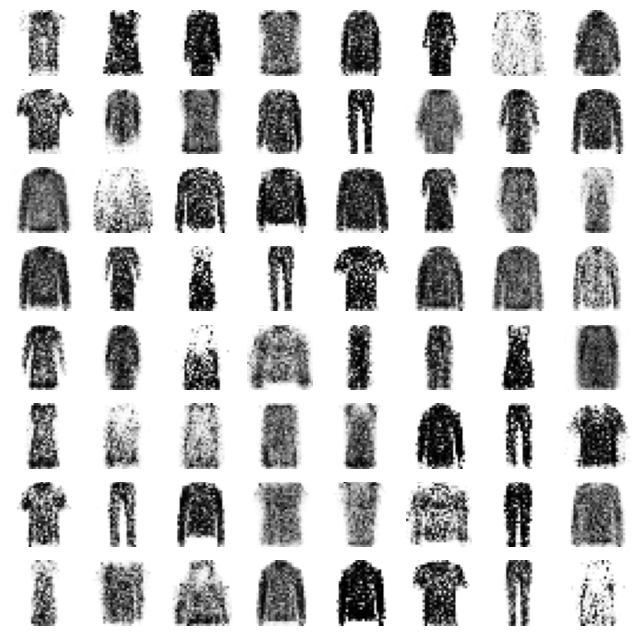

In [33]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for X_batch in dataset:

            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.train_on_batch(X_fake_and_real, y1)

            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)

    plot_multiple_images(generated_images.numpy(), 8)
    plt.show()

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
        
train_gan(gan, dataset, batch_size, codings_size, n_epochs=10)